### Take in the fits file and create a pupil to feed into FT_model code

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math
from math import tan, atan, hypot
from FT_model import model_FT
from fits_to_pupil import generate_pupil
from mpl_toolkits.axes_grid1 import make_axes_locatable
from radial_gradient import RWGE
from power_region import power_ratio
from symmetry import create_symmetry

In [2]:
pupils = []
for i in range(10):
    if i == 0 or i == 5:
        continue
    pupil_name = "ToliBoy_Pupil_Designs/ToliBoy_Pupil_{}.fits".format(i+1)
    pupil = generate_pupil(fits.open(pupil_name)[0].data)
    pupils.append(pupil)

---------

### Calculate fringe to pixel ratio 

$
\lambda = 525nm \\
Diameter = 0.018m \\
Focal\ length = 0.15m \\
Pixel\ size = 1.12\mu m 
$

In [3]:
aperture = 0.018                 # Aperture (m)
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-6                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)
lam = 525e-9
r_max = 60
size = 200
num_fringes = 10.5

physical_radius = fl*tan(num_fringes*lam/aperture)
num_pixels = physical_radius/detector_pitch
fringe_radii = num_pixels

fringes = atan(r_max*detector_pitch/fl)*aperture/lam
xvals = np.linspace(0, fringes, r_max)

Region size: 10.5 λ/D


Maximise:
   RWGE:		33.93
   RWGE inside region:	32.93
   % Power in region:	74.24 %
Minimise:
   Peak pixel value:	67.18
   Central pixel value:	15.30


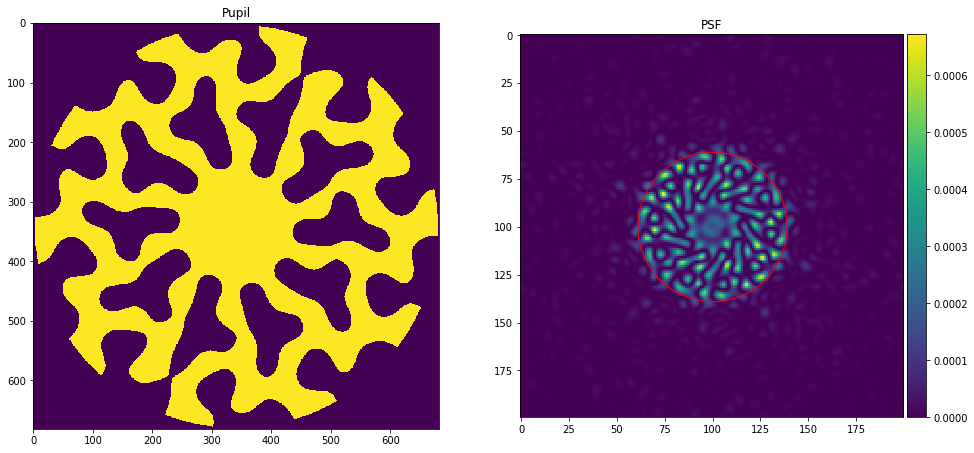

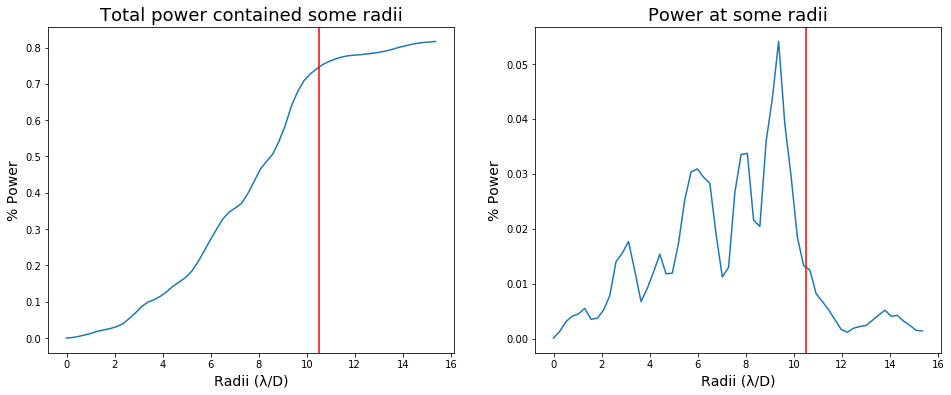

/Users/louis/Pupil_design/Pupil_simulations/symmetry.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  B[i][j] += A[k][l]/f




Maximise:
   RWGE:		38.49
   RWGE inside region:	37.48
   % Power in region:	79.79 %
Minimise:
   Peak pixel value:	63.30
   Central pixel value:	17.20


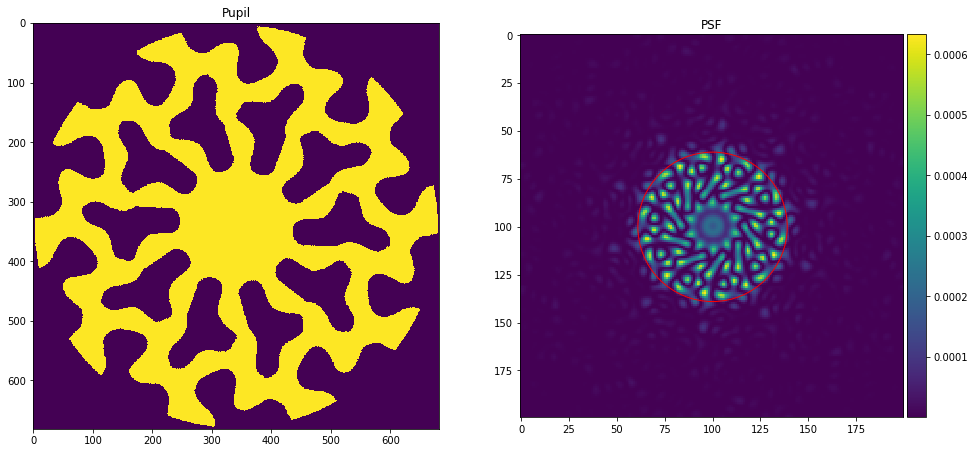

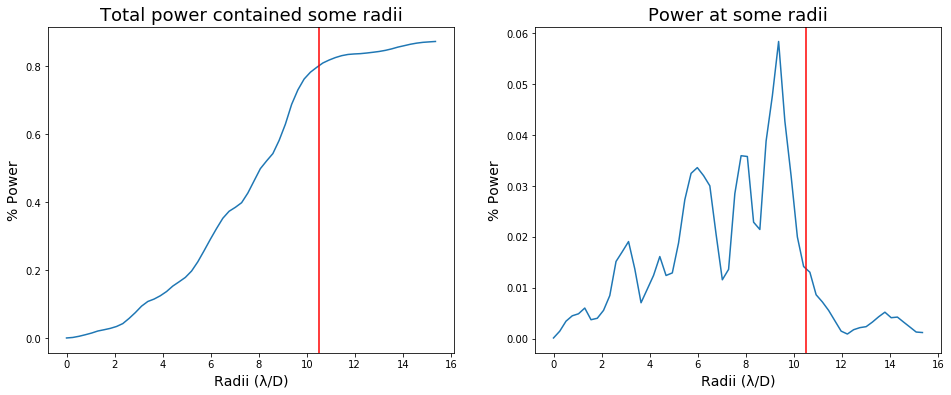



Maximise:
   RWGE:		43.26
   RWGE inside region:	42.18
   % Power in region:	68.81 %
Minimise:
   Peak pixel value:	86.19
   Central pixel value:	66.82


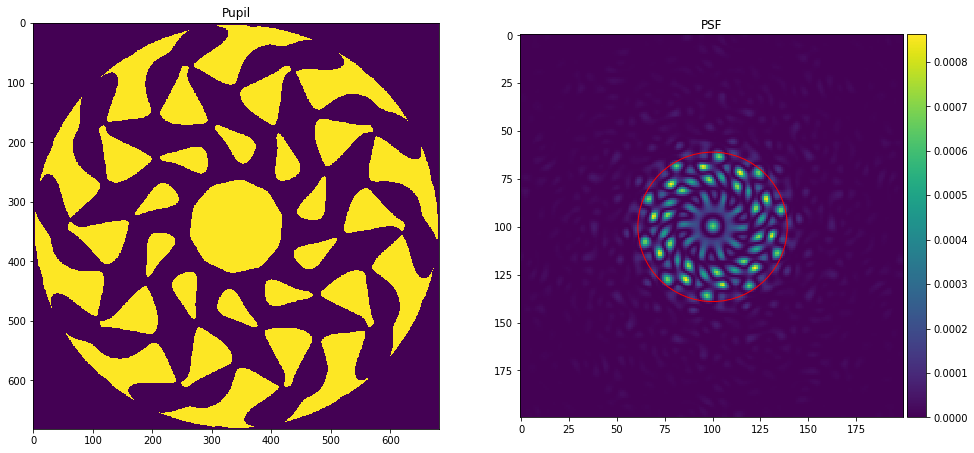

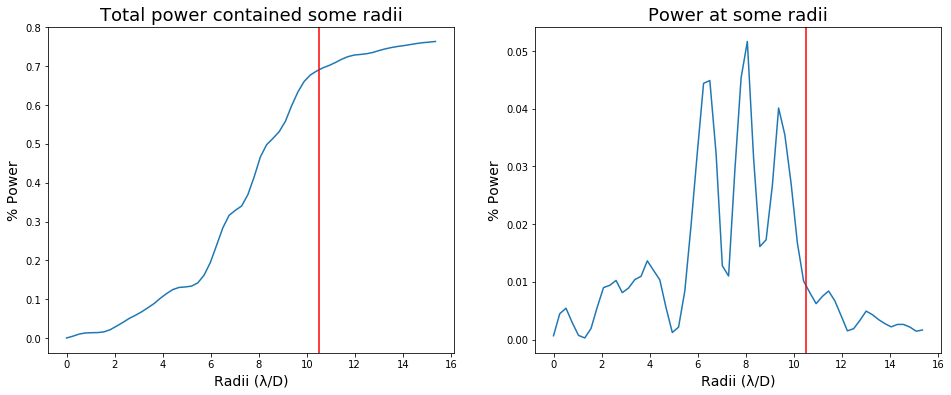



Maximise:
   RWGE:		41.74
   RWGE inside region:	41.20
   % Power in region:	75.40 %
Minimise:
   Peak pixel value:	77.65
   Central pixel value:	24.34


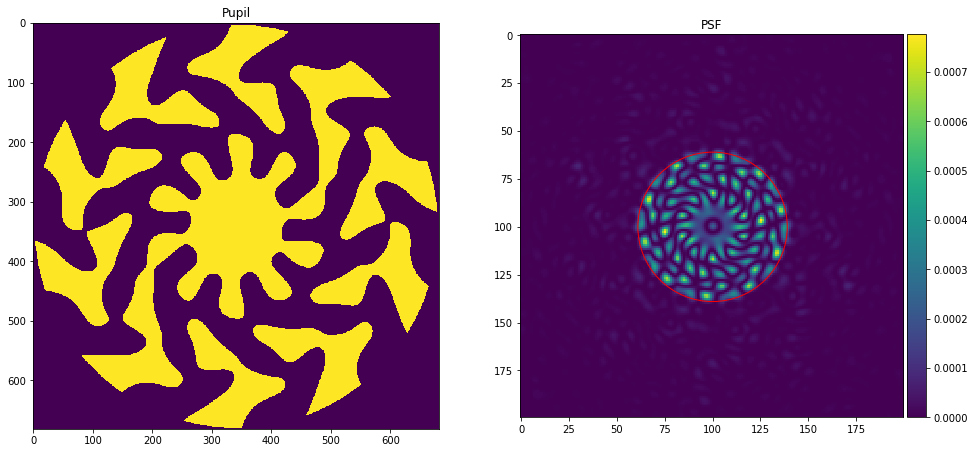

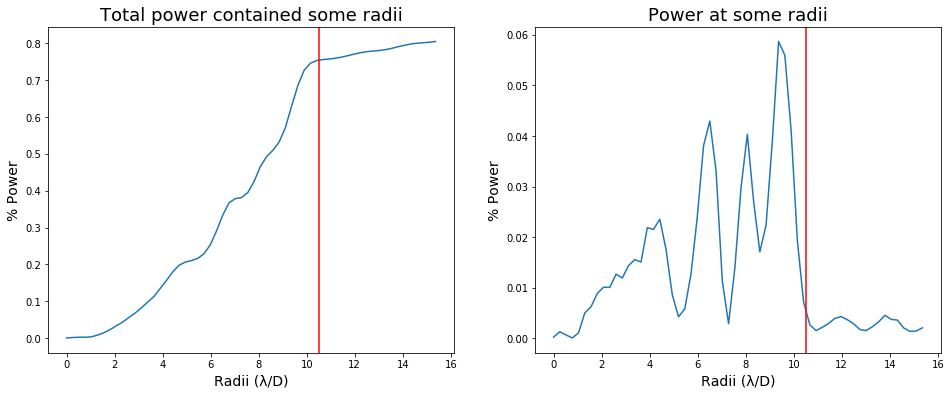



Maximise:
   RWGE:		47.47
   RWGE inside region:	46.98
   % Power in region:	80.11 %
Minimise:
   Peak pixel value:	75.06
   Central pixel value:	26.09


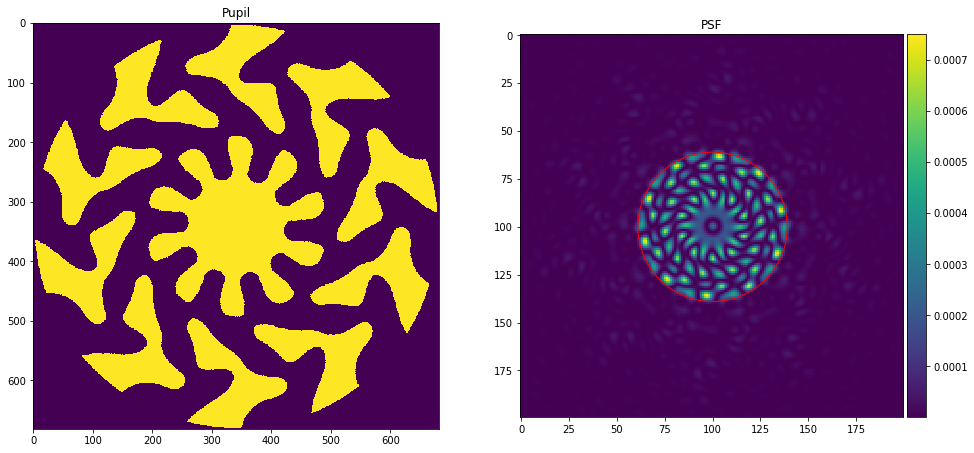

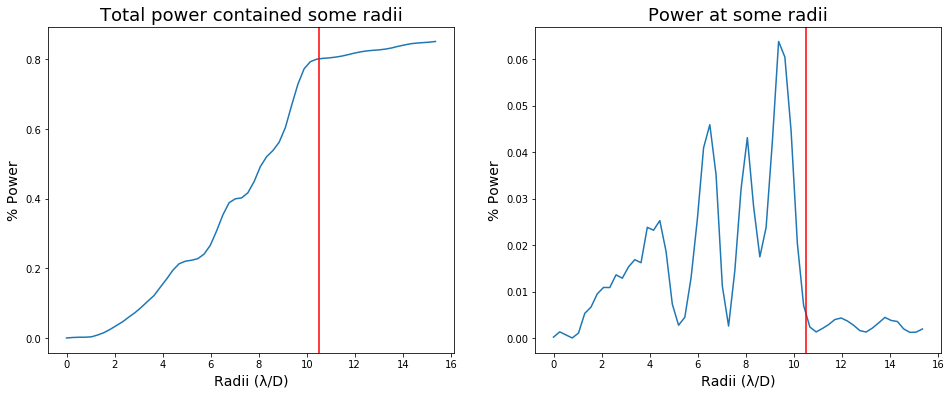



Maximise:
   RWGE:		50.16
   RWGE inside region:	49.79
   % Power in region:	78.75 %
Minimise:
   Peak pixel value:	78.30
   Central pixel value:	77.76


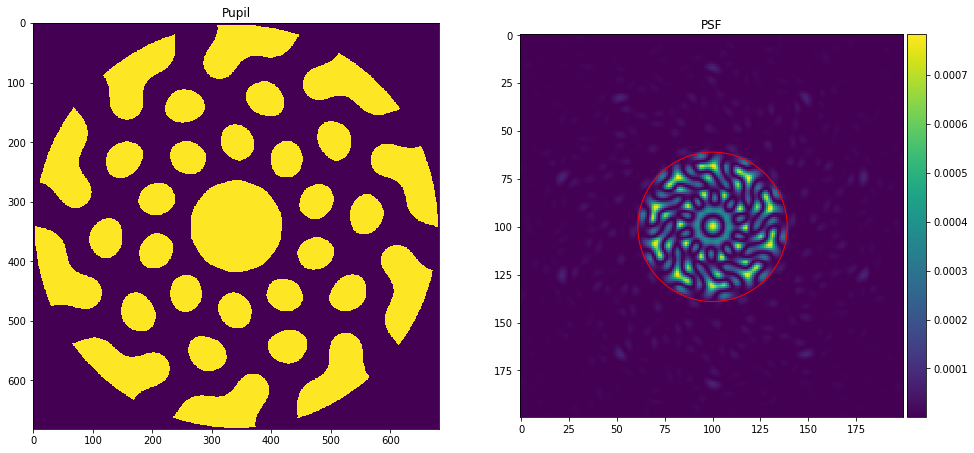

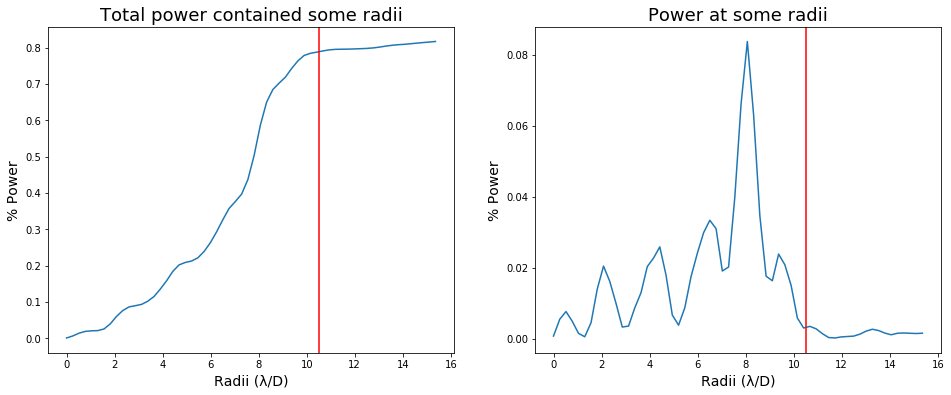



Maximise:
   RWGE:		24.70
   RWGE inside region:	12.78
   % Power in region:	38.05 %
Minimise:
   Peak pixel value:	59.16
   Central pixel value:	1.86


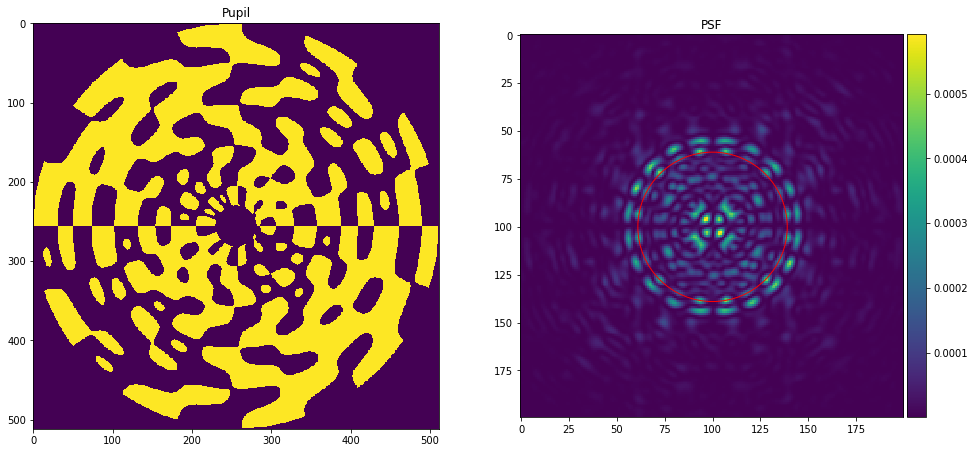

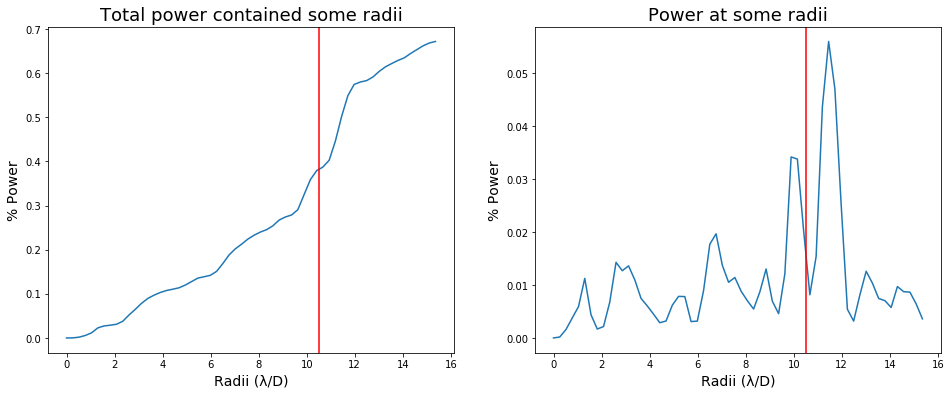



Maximise:
   RWGE:		19.46
   RWGE inside region:	13.25
   % Power in region:	49.97 %
Minimise:
   Peak pixel value:	43.37
   Central pixel value:	7.32


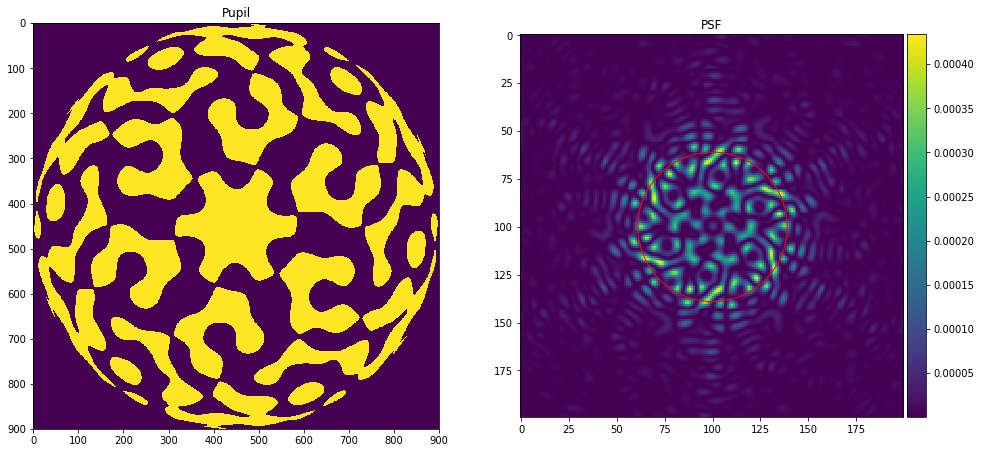

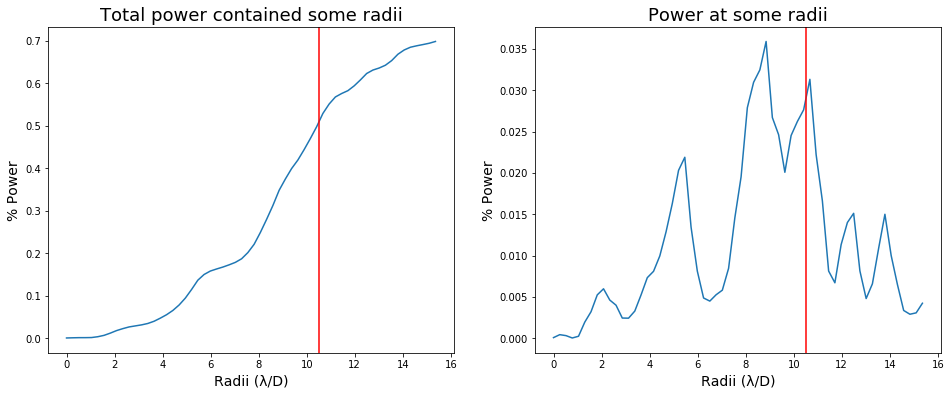



Maximise:
   RWGE:		22.43
   RWGE inside region:	16.68
   % Power in region:	53.49 %
Minimise:
   Peak pixel value:	35.56
   Central pixel value:	13.78


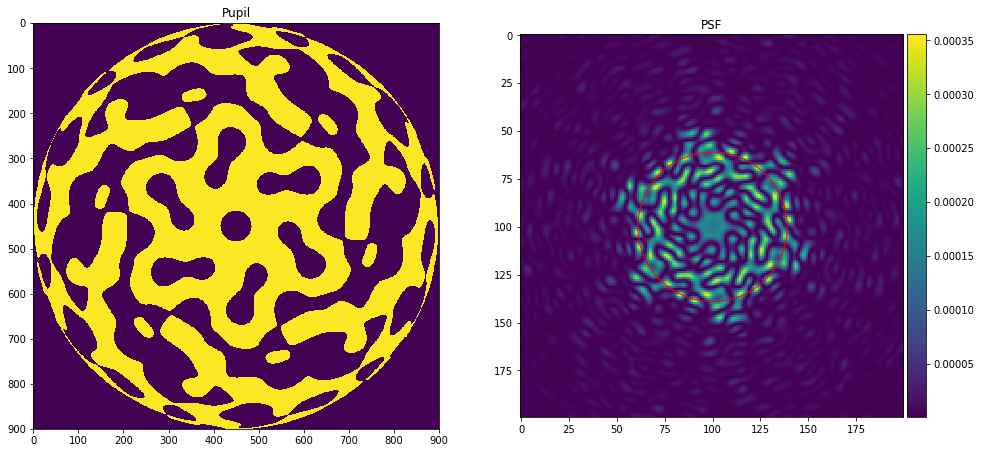

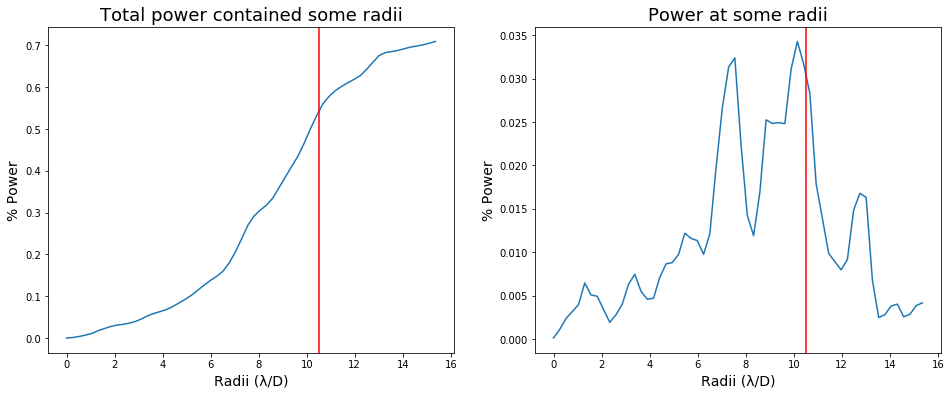



Maximise:
   RWGE:		37.00
   RWGE inside region:	36.33
   % Power in region:	76.38 %
Minimise:
   Peak pixel value:	65.99
   Central pixel value:	4.61


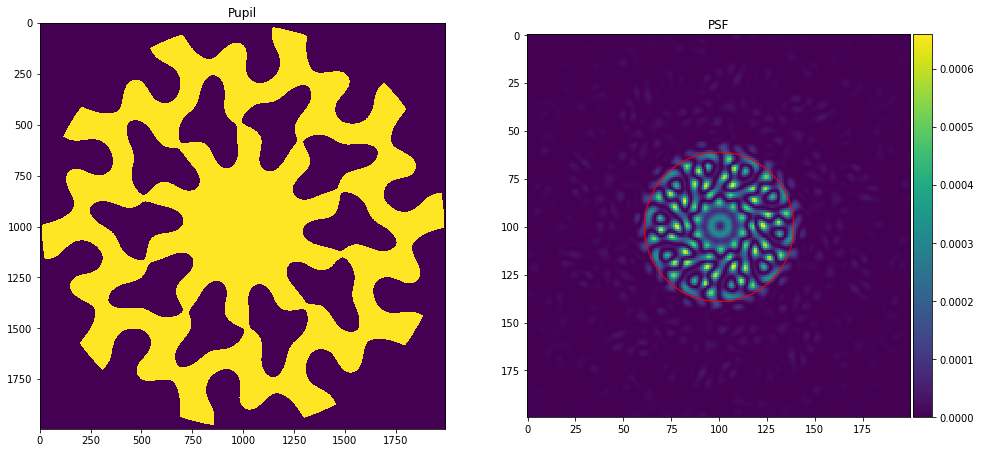

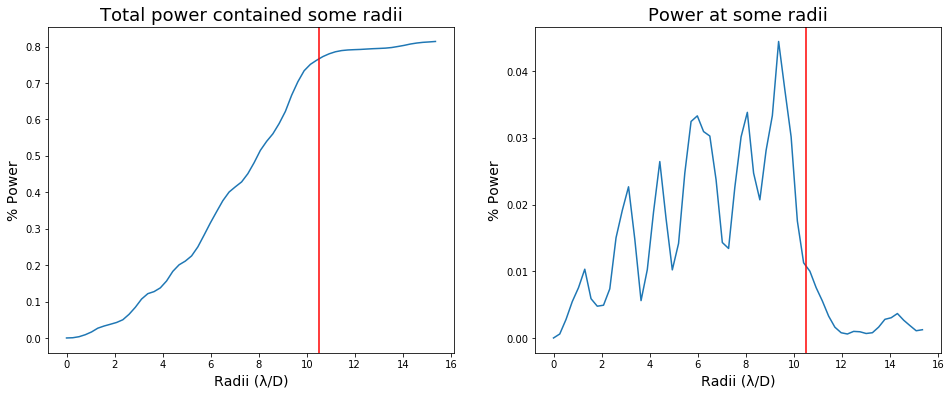

In [4]:
print("Region size: {} \u03BB/D".format(num_fringes))
for i in range(len(pupils)):
    pupil = pupils[i]
    # Try both symmetric and non symmetric pupils
    for j in range(2):
        
        if j == 0:
            pupil_in = pupil
        elif j == 1 and i not in [1, 3, 4, 5, 6, 7, 8]:
            pupil_in = create_symmetry(pupil, 10)
        else:
            continue
            
        im_out = model_FT(pupil_in, aperture, npixels, [wl], fl, detector_pitch)
        im_out = im_out/np.sum(im_out)
        
        fig, axs = plt.subplots(1, 2, figsize=(16,16))
        im = axs[0].imshow(np.abs(np.angle(pupil_in)))
        axs[0].set_title("Pupil")
        
        E_in = "{:.2f}".format(RWGE(im_out, max=fringe_radii)*1e6)
        E = "{:.2f}".format(RWGE(im_out)*1e6)
        R = "{:.2f}".format(power_ratio(im_out, fringe_radii)*100)
        P = "{:.2f}".format(np.max(im_out)*1e5)
        C = "{:.2f}".format(im_out[im_out.shape[0]//2][im_out.shape[0]//2]*1e5)
        
        print("\n\nMaximise:\n   RWGE:\t\t{}\n   RWGE inside region:\t{}\n   % Power in region:\t{} %\nMinimise:\n   Peak pixel value:\t{}\n   Central pixel value:\t{}".format(E, E_in, R, P, C))
    
        gridsize = im_out.shape[0]
        c = gridsize//2
        im = axs[1].imshow(im_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)])
        axs[1].set_title("PSF")

        circle = plt.Circle((size//2, size//2), 39, color='r', fill=False)
        axs[1].add_artist(circle)

        plt.colorbar(im, cax=make_axes_locatable(axs[1]).append_axes("right", size="5%", pad=0.05))
        plt.show() 
        
        regions = np.zeros(npixels)
        for k in range(npixels):
            for l in range(npixels):
                x = k - c
                y = l - c
                r = int(hypot(x, y))
                regions[r] += im_out[k][l]

        cum_sum = np.zeros(npixels)
        for k in range(len(regions)):
            if k == 0:
                cum_sum[k] = regions[k]
            else:
                cum_sum[k] = cum_sum[k-1] + regions[k]
                
        fig, axs = plt.subplots(1, 2, figsize=(16,6))
        
        im = axs[0].plot(xvals[:r_max],cum_sum[:r_max])
        axs[0].set_title("Total power contained some radii", fontsize=18)
        axs[0].set_xlabel("Radii (\u03BB/D)", fontsize=14)
        axs[0].set_ylabel("% Power", fontsize=14)
        axs[0].axvline(x=num_fringes, color='r')

        im = axs[1].plot(xvals[:r_max],regions[:r_max])
        axs[1].set_title("Power at some radii", fontsize=18)
        axs[1].set_xlabel("Radii (\u03BB/D)", fontsize=14)
        axs[1].set_ylabel("% Power", fontsize=14) 
        axs[1].axvline(x=num_fringes, color='r')
        
        plt.show()